# Continuous Control 
In this project, we seek to solve the Unity Reacher problem. A set of double-jointed arms exist in the field and the goal is to manipulate these arms so that the end of the arm is in the goal location (where the ball is). A positive reward of 0.1 is provided for each time step when the goal is met. The definition of solved for the Udacity task is that an average game score of >30 across 20 of these agents is achieved over the course of 100 games.

In [1]:
from IPython.display import HTML

# Youtube
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/2N9EoF6pQyE" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

/home/kevin/anaconda3/envs/drlnd/lib/python3.6/site-packages/IPython/core/display.py:689: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


# Approach
The approach here is to follow the [Deep Deterministic Policy Gradients (DDPG) algorithm](https://arxiv.org/pdf/1509.02971.pdf). We seek to optimize a policy that is used to identify an action within a continuous action space. In this case, the action manipulates the two joints in the arm by values ranging between -1 and 1. The value of the policy at a given time step is approximated using Deep Q Learning where the action taken from at the time step t is that identified by the policy. The optimum policy is one that maximizes this value. 

# Background
We define a *policy* $\pi$ as the probability that a given action $a$ is taken when the agent is in a particular state $s$. The goal is to approximate an optimal set of parameters $\theta$ such that $\pi_{\theta}$ maximizes the expected return. 

$$J(\theta) = \mathbb{E}[\sum_{t=0}^{T-1}r_{t+1} | \pi_{\theta}]$$
where $r_t$ is the return at timestep t and $\pi_{\theta}$ is the policy parameterized by theta. Equivalently,  
$$J(\theta) = \mathbb{E}[Q(s,a)|_{s=s_t,a_t=\mu(s_t)}]$$
where $Q(s,a)$ is the expected return of selecting action $a$ from policy $\mu$ at state $s$ and timestep $t$. 

The actor in an actor-critic method selects an action from a *policy* while the critic in the DDPG algorithm estimates the value of selecting a given action from a given state essentially following the DQN algorithm. We learn the actor and the critic in parallel and they inform each other.

## Algorithm
for episode=1,M do  
>for t=1,T do  
>>  Select an action $a_t$ according to the current policy $\mu$ subject to some external noise $N_t$,  
>>  $a_t = \mu(s_t|\theta^{\mu}) + N_t$  
>>  Execute action $a_t$ and observe reward $r_t$ and next state $s_{t+1}$  
>>  Store transition ($s_t$,$a_t$,$r_t$,$s_{t+1}$) in the replay buffer R  
>>  Sample a mini-batch of $N$ transitions from R ($s_i$,$a_i$,$r_i$,$s_{t+1}$)  
>>  Calculate the expected return for each sampled transition using the target value network and target policy  
>>  $y_i = r_i + \gamma Q'(s_{i+1},\mu'(s_{i+1} | \theta^{\mu^{'}} ) | \theta^{Q^{'}})$  
>>  Update the local critic network by minimizing the mean-squared error.
>>  For each entry, calculate the delta between the expected return using the current reward plus the expected future return versus the expected return from the current state and action  
>>  $L = \frac{1}{N}\sum_i(y_i - Q(s_i,a_i|\theta^Q))^2$  
>>  Update the local actor policy using the sampled policy gradient  
>>  $\nabla_{\theta^\mu} J \approx \frac{1}{N}\sum_i(\nabla_a Q(s,a|\theta^Q)|_{s=s_i,a=\mu(s_i)} \nabla_{\theta^\mu} \mu(s|\theta ^ \mu)) |_{s_i}$  
>>  Update the target networks  
>>  $\theta^{Q^{'}} \leftarrow \tau \theta^Q + (1 - \tau) \theta^{Q^{'}}$  
>>  $\theta^{\mu^{'}} \leftarrow \tau \theta^{\mu} + (1 - \tau) \theta^{\mu^{'}}$

## Implementation
First, define the actor and critic networks in model.py structured as defined in the ddpg paper as feed-forward two hidden layer networks with 400 units and 300 units respectively. Additionally, there is a batch normalization layer as also recommended in the paper.
```python
class Actor(nn.Module):
    """Actor (Policy) Model."""
    def __init__(self, state_size, action_size, seed, fc1_units=400, fc2_units=300, use_batch_norm=True):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()

        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)

        self.bn1 = nn.BatchNorm1d(fc1_units)
        
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)

        self.use_batch_norm = use_batch_norm
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        if self.use_batch_norm:
            x = F.relu(self.bn1(self.fc1(state)))
        else:
            x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return F.tanh(self.fc3(x))
```

```python
class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=400, fc2_units=300, use_batch_norm = True):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)

        self.bn1 = nn.BatchNorm1d(fc1_units)

        self.fc2 = nn.Linear(fc1_units+action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)

        self.use_batch_norm = use_batch_norm

        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        if self.use_batch_norm:
            xs = F.relu(self.bn1(self.fc1(state)))
        else:
            xs = F.relu(self.fc1(state))
        x = torch.cat((xs, action), dim=1)
        x = F.relu(self.fc2(x))
        return self.fc3(x)
```

The DDPG agent acts upon these models. Extract the sections from the algorithm and illustrate the code implementation.

### Select an action $a_t$ according to the current policy $\mu$ subject to some external noise $N_t$  
$a_t = \mu(s_t|\theta^{\mu}) + N_t$  

```python
def act(self, state, add_noise=True):
    """Returns actions for given state as per current policy."""
    state = torch.from_numpy(state).float().to(device)
    self.actor_local.eval()
    with torch.no_grad():
        action = self.actor_local(state).cpu().data.numpy()
    self.actor_local.train()
    if add_noise:
        action += self.noise.sample()
    return np.clip(action, -1, 1)
```
Note that the implementation clips the action to the $[-1,1]$ range.  
### Noise sample $N_t$
So, we select an action using the local actor and add some noise. The noise defined in the algorithm is the [Ornstein-Uhlenbeck Noise Process](https://en.wikipedia.org/wiki/Ornstein%E2%80%93Uhlenbeck_process).
```python

class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2, random_fn=np.random.randn):
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.random_fn = random_fn
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array([self.random_fn() for i in range(len(x))])
        self.state = x + dx
        return self.state
```

### Execute action $a_t$, observe reward $r_t$, and next state $s_{t+1}$  
```python
            actions = agent.act(states)
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done
```
### Add sample to replay buffer
```python
    def step(self, states, actions, rewards, next_states, dones):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        # Save experience / reward

        for state, action, reward, next_state, done in zip(states,actions,rewards, next_states, dones):
            self.memory.add(state, action, reward, next_state, done)
```
### Calculate the expected return
  $y_i = r_i + \gamma Q'(s_{i+1},\mu'(s_{i+1} | \theta^{\mu^{'}} ) | \theta^{Q^{'}})$  
  $\mu^{'}$ is the actor_target and $Q^{'}$ is the critic target  
```python
        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
```
### Calculate the critic loss
 $L = \frac{1}{N}\sum_i(y_i - Q(s_i,a_i|\theta^Q))^2$  

```python
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
         
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.critic_local.parameters(), 1)
        self.critic_optimizer.step()
```
### Update the local actor policy using the sampled policy gradient  
$\nabla_{\theta^\mu} J \approx \frac{1}{N}\sum_i(\nabla_a Q(s,a|\theta^Q)|_{s=s_i,a=\mu(s_i)} \nabla_{\theta^\mu} \mu(s|\theta ^ \mu)) |_{s_i}$  
pytorch's autograd function means we really just need to calculate the mean Q value using the actions from the local actor. We invert the result so that the Adam optimizer will search for the minimum.  
```python
        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.actor_local.parameters(), 1)
        self.actor_optimizer.step()
```
### Update the target networks
$\theta^{Q^{'}} \leftarrow \tau \theta^Q + (1 - \tau) \theta^{Q^{'}}$  
$\theta^{\mu^{'}} \leftarrow \tau \theta^{\mu} + (1 - \tau) \theta^{\mu^{'}}$  
The target network update is performed in the soft_update method  
```python
        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)
```

# Results Analysis
The following few code cells are used for analyzing experimental results. First, we read in the experimental files then we define a function to easily illustrate the impact when modifying only a single variable.

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import numpy as np
sns.set()

In [3]:
all_scores = []
for batch_size in [64,128,256]:
    for buffer_size in [100000,1000000]:
        for use_batch_norm in ["False", "True"]:
            for random_fn in ["normal"]:
                fname = 'data/time_and_scores_{batch_size}_{buffer_size}_{use_batch_norm}_{random_fn}.pkl'.format(
                    batch_size=batch_size, buffer_size=buffer_size, use_batch_norm=use_batch_norm, random_fn=random_fn)
                time_and_scores = pickle.load(open(fname, 'rb'))
                epoch = 0
                for s in time_and_scores[1]:
                    all_scores.append((fname, batch_size, buffer_size, use_batch_norm, random_fn, epoch, s))     
                    epoch += 1
df=pd.DataFrame(data=all_scores)
df.columns=['fname', 'batch_size', 'buffer_size', 'use_batch_norm', 'random_fn', 'epoch', 'score']

In [4]:
def display_conditional_performance(df, conditions, labels, title=""):
    my_df_scores = {}
    for i in range(len(labels)):
        cond_field, cond_value = conditions[i]
        label = labels[i]
        my_df = df[df[cond_field] == cond_value]
        my_df_scores[label] = []
        for epoch in range(50):
            my_df_scores[label].append(np.mean(my_df.score[my_df.epoch == epoch]))
    g=sns.relplot(data=pd.DataFrame(my_df_scores))
    g.fig.suptitle(title)
    g.fig.subplots_adjust(top=.9)


# Model Search
We executed a smaller number of episodes, 50, with and without the batch normalization layer to establish the impact on performance. The results convincingly show that batch normalization is desirable.

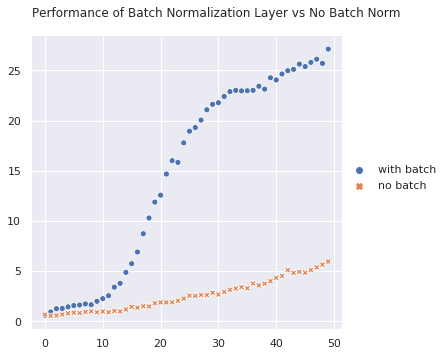

In [5]:
display_conditional_performance(df,
                                [['use_batch_norm','True'], ['use_batch_norm', 'False']], 
                                ['with batch','no batch'],
                               "Performance of Batch Normalization Layer vs No Batch Norm")

# Hyperparameter Selection

$\gamma = 0.99$ defines the future rewards discount   
$\tau = 0.001$ defines the soft update rate for the target network parameters   
$\alpha_a = 0.001$ defines the learning rate for the actor model  
$\alpha_c = 0.001$ defines the learning rate for the critic model

We run scenarios with and without batch normalization, with uniform versus normally distributed noise, with multiple batch sizes, and multiple buffer sizes. Below we show the combined results varying only one of the parameters at a time to illustrate parameters most likely to be successful.

## Buffer Size 
The buffer size does not show as dramatic a difference in the performance though the larger buffer does seem to improve performance.

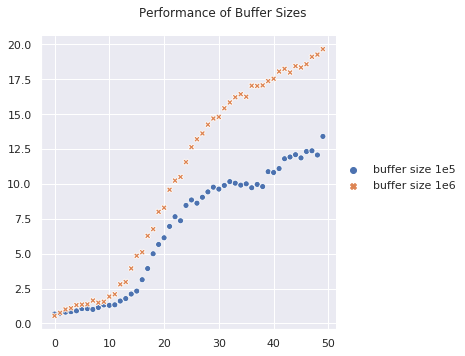

In [6]:
display_conditional_performance(df, 
                                [['buffer_size',100000],['buffer_size',1000000]], 
                                ['buffer size 1e5','buffer size 1e6'],
                               "Performance of Buffer Sizes")

## Mini-Batch Size
Finally, we look at the impact of three different mini-batch sizes of 64 versus 128 versus 256 samples. The larger mini-batch does perform better but all batch sizes seem to learn.

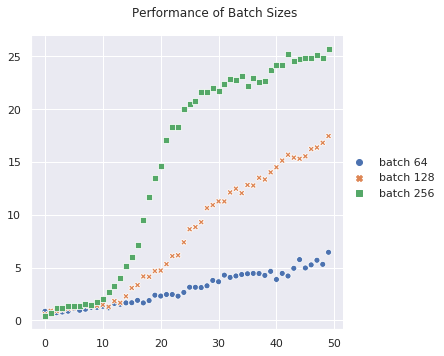

In [7]:
display_conditional_performance(df, 
                                [['batch_size',64],['batch_size',128], 
                                 ['batch_size',256]], 
                                ['batch 64','batch 128','batch 256'],
                               "Performance of Batch Sizes")

# Results

Based upon the model selection experiment and the buffer size and batch size experiments, for the official scoring we used batch normalization, a mini-batch size of 128, and a buffer size of 1e6.

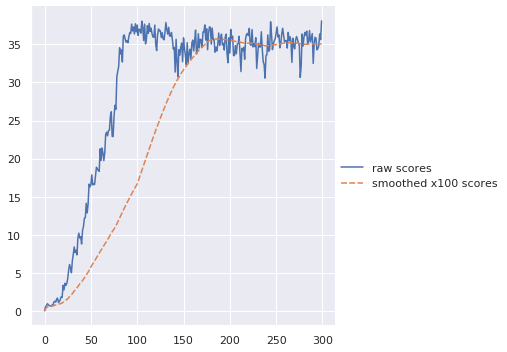

In [8]:
time_and_scores = pickle.load(open('data/time_and_scores_128_1000000_True_normal_official.pkl', 'rb'))
scores = time_and_scores[1]
d = {'raw scores':scores, 'smoothed x100 scores':[]}
d['smoothed x100 scores'] = [np.mean(scores[max(i-100,0):i+1]) for i in range(len(scores))]
pdf = pd.DataFrame(d)
ax=sns.relplot(data=pdf,kind='line')

In [9]:
print("Smoothed Score exceeded 30 at {}".format(pdf.index[pdf['smoothed x100 scores'] > 30][0]))

Smoothed Score exceeded 30 at 142


The average score over 100 samples exceeds the threshold of 30 in episode 142 thereby meeting the project requirement. The plot of the raw averages shows that the variance isn't very large. 

## Pre-Trained Model Results
The video below was created with the trained model. You will see that the end affector is generally touching the ball.

In [10]:
from IPython.display import Video

Video("./reacher_trained.mp4")

Below are the average scores across 20 pre-trained agents over the course of five episodes. As expected from the training results, the model seems to perform well above the requirement.

In [11]:
import pickle
mean_scores = pickle.load(open('./data/trained_model_scores.pkl','rb'))
for i, score in enumerate(mean_scores):
    print("Episode {} produced mean score {:.3f}".format(i+1, score))

Episode 1 produced mean score 37.354
Episode 2 produced mean score 38.080
Episode 3 produced mean score 37.039
Episode 4 produced mean score 37.217
Episode 5 produced mean score 38.076


# Recommendations for Future Work
- Experiment with deeper architectures. The model used follows directly from that used in the original DDPG paper. It is possible that a deeper architecture would learn quicker or achieve higher scores over time.
- Experiment with the model width. The model chosen uses 400 and 300 units in the two respective hidden layers. Increasing or decreasing the number of units in the hidden layers may impact performance.
- Apply the same model and agent to the single agent problem to see how efficiently the model converges towards the solution for that problem.
- Apply the algorithmic improvements recommended in the D4PG paper, such as prioritized experience replay, to the DDPG solution and examine the impact on the convergence curve.